In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 12-33-01.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30  
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 12-33-01_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_04.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752193367.144399 23272961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752193367.153087 23273648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752193367.162050 23273648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752193391.586615 23273650 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 17331
Frames with at least 1 hand detected: 13193
Detection rate: 76.12%


In [8]:
df = pd.read_csv("hand_landmarks_04.csv")

print("Shape:", df.shape)
df

Shape: (513765, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.00,Left,0,NaN,NaN,NaN,0
1,0,0.00,Left,1,NaN,NaN,NaN,0
2,0,0.00,Left,2,NaN,NaN,NaN,0
3,0,0.00,Left,3,NaN,NaN,NaN,0
4,0,0.00,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
513760,17330,288.85,Right,16,NaN,NaN,NaN,0
513761,17330,288.85,Right,17,NaN,NaN,NaN,0
513762,17330,288.85,Right,18,NaN,NaN,NaN,0
513763,17330,288.85,Right,19,NaN,NaN,NaN,0


In [11]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [14]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,283,4.717,Left,1,0.611040,0.576913,0.540218,0.504053,0.472452,0.586618,...,0.039626,0.034010,0.043937,0.057913,0.049639,0.040403,0.059349,0.066158,0.063253,0.060525
1,284,4.733,Left,1,0.604040,0.577577,0.544213,0.509598,0.479282,0.586650,...,0.037560,0.031488,0.041958,0.053706,0.048067,0.041716,0.054030,0.059592,0.058578,0.057560
2,285,4.750,Left,1,0.601456,0.572024,0.539228,0.504223,0.472202,0.587406,...,0.029493,0.022626,0.041317,0.051208,0.043191,0.035556,0.056135,0.059949,0.056791,0.054509
3,286,4.767,Left,1,0.599704,0.571559,0.537538,0.500435,0.468448,0.586656,...,0.020779,0.013383,0.036869,0.044101,0.035056,0.027286,0.052918,0.054792,0.051012,0.048663
4,287,4.783,Left,1,0.599647,0.569630,0.536381,0.500076,0.466443,0.588529,...,0.026631,0.022518,0.036533,0.047035,0.044453,0.041037,0.053871,0.058902,0.059696,0.060661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15254,16705,278.417,Left,1,0.631398,0.618422,0.598704,0.570554,0.550974,0.602149,...,0.057199,0.054461,0.064605,0.074621,0.064830,0.059047,0.080211,0.087292,0.083212,0.081119
15255,16706,278.433,Left,1,0.630306,0.615373,0.595510,0.568829,0.550159,0.599940,...,0.061292,0.059588,0.064756,0.074408,0.065123,0.060161,0.077080,0.082821,0.078175,0.076268
15256,16707,278.450,Left,1,0.627288,0.617240,0.598834,0.570605,0.549901,0.600578,...,0.055679,0.053029,0.062607,0.072551,0.063919,0.058963,0.076945,0.083456,0.080016,0.078619
15257,16785,279.750,Left,1,0.521420,0.511602,0.506341,0.502475,0.499541,0.512747,...,0.065495,0.065628,0.033736,0.050300,0.051224,0.049503,0.026068,0.037077,0.040524,0.041887


In [17]:
df2 = pd.read_csv("hand_lable_04.csv")

print("Shape:", df.shape)
df2

Shape: (513765, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,other,NaN,START,55.650,D:/Data Science/UOB/DS_project/Full Study/04/2...,3339,NaN,NaN
1,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,other,NaN,STOP,60.850,D:/Data Science/UOB/DS_project/Full Study/04/2...,3651,NaN,NaN
2,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,lift,NaN,START,60.867,D:/Data Science/UOB/DS_project/Full Study/04/2...,3652,NaN,NaN
3,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,lift,NaN,STOP,61.900,D:/Data Science/UOB/DS_project/Full Study/04/2...,3714,NaN,NaN
4,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,hold,NaN,START,61.917,D:/Data Science/UOB/DS_project/Full Study/04/2...,3715,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,hold,NaN,STOP,277.533,D:/Data Science/UOB/DS_project/Full Study/04/2...,16652,NaN,NaN
222,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,place,NaN,START,277.550,D:/Data Science/UOB/DS_project/Full Study/04/2...,16653,NaN,NaN
223,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,place,NaN,STOP,279.950,D:/Data Science/UOB/DS_project/Full Study/04/2...,16797,NaN,NaN
224,4,2025-07-08 14:34:08.670,NaN,227.25,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,288.85,60.0,NaN,other,NaN,START,279.967,D:/Data Science/UOB/DS_project/Full Study/04/2...,16798,NaN,NaN


In [20]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,55.650,60.850,3339,3651
1,lift,60.867,61.900,3652,3714
2,hold,61.917,64.817,3715,3889
3,press,64.833,65.450,3890,3927
4,hold,65.467,65.883,3928,3953
...,...,...,...,...,...
108,hold,274.417,274.700,16465,16482
109,press,274.717,277.183,16483,16631
110,hold,277.200,277.533,16632,16652
111,place,277.550,279.950,16653,16797


In [23]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_8732/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,283,4.717,Left,1,0.611040,0.576913,0.540218,0.504053,0.472452,0.586618,...,0.034010,0.043937,0.057913,0.049639,0.040403,0.059349,0.066158,0.063253,0.060525,NaN
1,284,4.733,Left,1,0.604040,0.577577,0.544213,0.509598,0.479282,0.586650,...,0.031488,0.041958,0.053706,0.048067,0.041716,0.054030,0.059592,0.058578,0.057560,NaN
2,285,4.750,Left,1,0.601456,0.572024,0.539228,0.504223,0.472202,0.587406,...,0.022626,0.041317,0.051208,0.043191,0.035556,0.056135,0.059949,0.056791,0.054509,NaN
3,286,4.767,Left,1,0.599704,0.571559,0.537538,0.500435,0.468448,0.586656,...,0.013383,0.036869,0.044101,0.035056,0.027286,0.052918,0.054792,0.051012,0.048663,NaN
4,287,4.783,Left,1,0.599647,0.569630,0.536381,0.500076,0.466443,0.588529,...,0.022518,0.036533,0.047035,0.044453,0.041037,0.053871,0.058902,0.059696,0.060661,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15254,16705,278.417,Left,1,0.631398,0.618422,0.598704,0.570554,0.550974,0.602149,...,0.054461,0.064605,0.074621,0.064830,0.059047,0.080211,0.087292,0.083212,0.081119,place
15255,16706,278.433,Left,1,0.630306,0.615373,0.595510,0.568829,0.550159,0.599940,...,0.059588,0.064756,0.074408,0.065123,0.060161,0.077080,0.082821,0.078175,0.076268,place
15256,16707,278.450,Left,1,0.627288,0.617240,0.598834,0.570605,0.549901,0.600578,...,0.053029,0.062607,0.072551,0.063919,0.058963,0.076945,0.083456,0.080016,0.078619,place
15257,16785,279.750,Left,1,0.521420,0.511602,0.506341,0.502475,0.499541,0.512747,...,0.065628,0.033736,0.050300,0.051224,0.049503,0.026068,0.037077,0.040524,0.041887,place


In [26]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    4414
hold      2679
NaN       2211
adjust    2123
other     1599
press     1303
place      661
lift       269
Name: count, dtype: int64


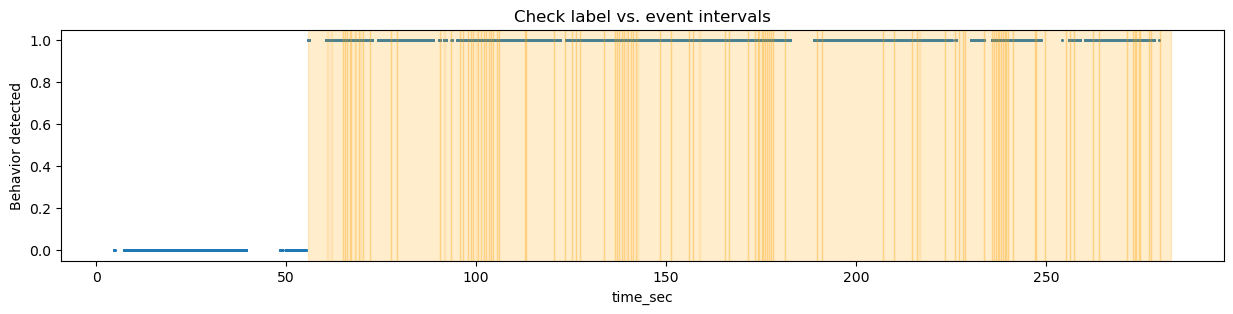

In [29]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [38]:
df_wide[(df_wide['time_sec'] <= 60.917)][['time_sec', 'behavior']]

,time_sec,behavior
0,4.717,NaN
1,4.733,NaN
2,4.750,NaN
3,4.767,NaN
4,4.783,NaN
...,...,...
2242,60.583,other
2243,60.600,other
2244,60.617,other
2245,60.633,other


In [43]:
df_wide[(df_wide['time_sec'] <= 236.717)][['time_sec', 'behavior']]

,time_sec,behavior
0,4.717,NaN
1,4.733,NaN
2,4.750,NaN
3,4.767,NaN
4,4.783,NaN
...,...,...
12610,236.650,hold
12611,236.667,hold
12612,236.683,hold
12613,236.700,hold


In [45]:
df_wide[(df_wide['time_sec'] <= 277.550)][['time_sec', 'behavior']]

,time_sec,behavior
0,4.717,NaN
1,4.733,NaN
2,4.750,NaN
3,4.767,NaN
4,4.783,NaN
...,...,...
15198,277.483,hold
15199,277.500,hold
15200,277.517,hold
15201,277.533,hold


In [48]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
2211,3348,55.800,Left,1,0.574183,0.539981,0.510035,0.495145,0.491404,0.497276,...,-0.011495,-0.007811,-0.003560,-0.001519,-0.001305,-0.005615,-0.000364,0.005062,0.009105,other
2212,3349,55.817,Left,1,0.570971,0.538554,0.510042,0.498147,0.497972,0.494835,...,-0.013658,-0.011443,-0.013805,-0.010405,-0.008190,-0.011048,-0.011425,-0.007180,-0.003580,other
2213,3351,55.850,Left,1,0.596427,0.562206,0.517658,0.484091,0.459329,0.518668,...,0.004129,0.017282,0.020922,0.018024,0.015045,0.026222,0.027677,0.028095,0.028912,other
2214,3352,55.867,Left,1,0.612966,0.581004,0.541629,0.510858,0.490904,0.539740,...,-0.013172,-0.003031,-0.009497,-0.011559,-0.011548,-0.005074,-0.008132,-0.005002,-0.001655,other
2215,3353,55.883,Left,1,0.612321,0.585752,0.552639,0.524737,0.505467,0.544405,...,-0.018528,-0.004908,-0.010675,-0.011304,-0.010750,-0.003836,-0.007393,-0.005434,-0.002873,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15254,16705,278.417,Left,1,0.631398,0.618422,0.598704,0.570554,0.550974,0.602149,...,0.054461,0.064605,0.074621,0.064830,0.059047,0.080211,0.087292,0.083212,0.081119,place
15255,16706,278.433,Left,1,0.630306,0.615373,0.595510,0.568829,0.550159,0.599940,...,0.059588,0.064756,0.074408,0.065123,0.060161,0.077080,0.082821,0.078175,0.076268,place
15256,16707,278.450,Left,1,0.627288,0.617240,0.598834,0.570605,0.549901,0.600578,...,0.053029,0.062607,0.072551,0.063919,0.058963,0.076945,0.083456,0.080016,0.078619,place
15257,16785,279.750,Left,1,0.521420,0.511602,0.506341,0.502475,0.499541,0.512747,...,0.065628,0.033736,0.050300,0.051224,0.049503,0.026068,0.037077,0.040524,0.041887,place


In [53]:
df_wide['dataset_id'] = '04'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
2211,04,3348,55.800,Left,1,0.574183,0.539981,0.510035,0.495145,0.491404,...,-0.011495,-0.007811,-0.003560,-0.001519,-0.001305,-0.005615,-0.000364,0.005062,0.009105,other
2212,04,3349,55.817,Left,1,0.570971,0.538554,0.510042,0.498147,0.497972,...,-0.013658,-0.011443,-0.013805,-0.010405,-0.008190,-0.011048,-0.011425,-0.007180,-0.003580,other
2213,04,3351,55.850,Left,1,0.596427,0.562206,0.517658,0.484091,0.459329,...,0.004129,0.017282,0.020922,0.018024,0.015045,0.026222,0.027677,0.028095,0.028912,other
2214,04,3352,55.867,Left,1,0.612966,0.581004,0.541629,0.510858,0.490904,...,-0.013172,-0.003031,-0.009497,-0.011559,-0.011548,-0.005074,-0.008132,-0.005002,-0.001655,other
2215,04,3353,55.883,Left,1,0.612321,0.585752,0.552639,0.524737,0.505467,...,-0.018528,-0.004908,-0.010675,-0.011304,-0.010750,-0.003836,-0.007393,-0.005434,-0.002873,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15254,04,16705,278.417,Left,1,0.631398,0.618422,0.598704,0.570554,0.550974,...,0.054461,0.064605,0.074621,0.064830,0.059047,0.080211,0.087292,0.083212,0.081119,place
15255,04,16706,278.433,Left,1,0.630306,0.615373,0.595510,0.568829,0.550159,...,0.059588,0.064756,0.074408,0.065123,0.060161,0.077080,0.082821,0.078175,0.076268,place
15256,04,16707,278.450,Left,1,0.627288,0.617240,0.598834,0.570605,0.549901,...,0.053029,0.062607,0.072551,0.063919,0.058963,0.076945,0.083456,0.080016,0.078619,place
15257,04,16785,279.750,Left,1,0.521420,0.511602,0.506341,0.502475,0.499541,...,0.065628,0.033736,0.050300,0.051224,0.049503,0.026068,0.037077,0.040524,0.041887,place


In [56]:
df_wide.to_csv("handlandmark_wide_04.csv", index=False)